In [131]:
import numpy as np 
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime

In [132]:
X = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/churchland.npy') 
X = jnp.array(X) 
print(X.shape)

(108, 218, 61)


In [133]:
def soft_normalize(X):
    X_norm_const = jnp.maximum(jnp.max(X, axis=(0,2),  keepdims=True ), 0.1)
    X_normalized = X / X_norm_const
    mean_across_conditions = jnp.mean(X_normalized, axis=0, keepdims=True) 
    X_normalized = X_normalized - mean_across_conditions
    return X_normalized


In [134]:
def single_pair_loss(U_tilde, X, id_1, id_2):                           #U (N,d); X(K,N,T)

    Y = jnp.einsum('ji,jk->ik', U_tilde, X[id_1, :, :])                 #(d,T)
    Y_prime = jnp.einsum('ji,jk->ik', U_tilde, X[id_2, :, :])           #(d,T)

    YY = jnp.einsum('ij,kj->ik', Y, Y_prime)                            #(d,d)
    YY_product = jnp.einsum('ij,lm->im', YY, YY)                        #(d,d)

    S_pair = jnp.trace(YY)**2 - jnp.trace(YY_product)
    return S_pair

def loss(U, X, key):  
    K, N, T = X.shape
    U_tilde, _ = jnp.linalg.qr(U)

    num_pairs = 10  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(U_tilde, X, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    S = (2 / (K**2) ) * jnp.sum(batched_loss)
    return -S

def update_U(U, X, optimizer, opt_state, key):
    dL_dU = grad(loss)(U,X,key)
  
    updates, opt_state_updated = optimizer.update(dL_dU, opt_state, U)
    U_updated = optax.apply_updates(U, updates)
    return U_updated, opt_state_updated

def optimize_U(X, iterations=10000, learning_rate=0.001, d=3, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    U = random.normal(key, (N, d))

    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(U)
    
    ls_loss = []

    for i in range(iterations):
        U, opt_state = update_U(U, X, optimizer, opt_state, keys[i])
        ls_loss.append(loss(U, X, keys[i]))
        
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss(U, X, keys[i])}")
    
    return U, ls_loss

optimized_U = optimize_U(soft_normalize(X))                     #optimized_U (N,d)

now = datetime.datetime.now()
date_time_str = now.strftime('%d%m%Y_%H%M%S')
file_name = 'optimized_U_linear_SCA/optimized_U_' + date_time_str
np.save(file_name, optimized_U[0])

Iteration 0, S: -0.00016907989629544318
Iteration 10, S: -0.0006819363334216177
Iteration 20, S: 0.00015413099026773125
Iteration 30, S: 6.348930764943361e-05
Iteration 40, S: 0.0024627246893942356
Iteration 50, S: 0.0027223597280681133
Iteration 60, S: 0.004400141537189484
Iteration 70, S: 0.005653596017509699
Iteration 80, S: 0.006379283964633942
Iteration 90, S: 0.006629668641835451
Iteration 100, S: 0.008945074863731861
Iteration 110, S: 0.015822067856788635
Iteration 120, S: 0.01840851455926895
Iteration 130, S: 0.019783833995461464
Iteration 140, S: 0.026587549597024918
Iteration 150, S: 0.04386353865265846
Iteration 160, S: 0.052114974707365036
Iteration 170, S: 0.07565401494503021
Iteration 180, S: 0.11319693922996521
Iteration 190, S: 0.11817911267280579
Iteration 200, S: 0.204934760928154
Iteration 210, S: 0.12253984063863754
Iteration 220, S: 0.24493743479251862
Iteration 230, S: -0.08418894559144974
Iteration 240, S: -0.024816546589136124
Iteration 250, S: 0.001267131650820

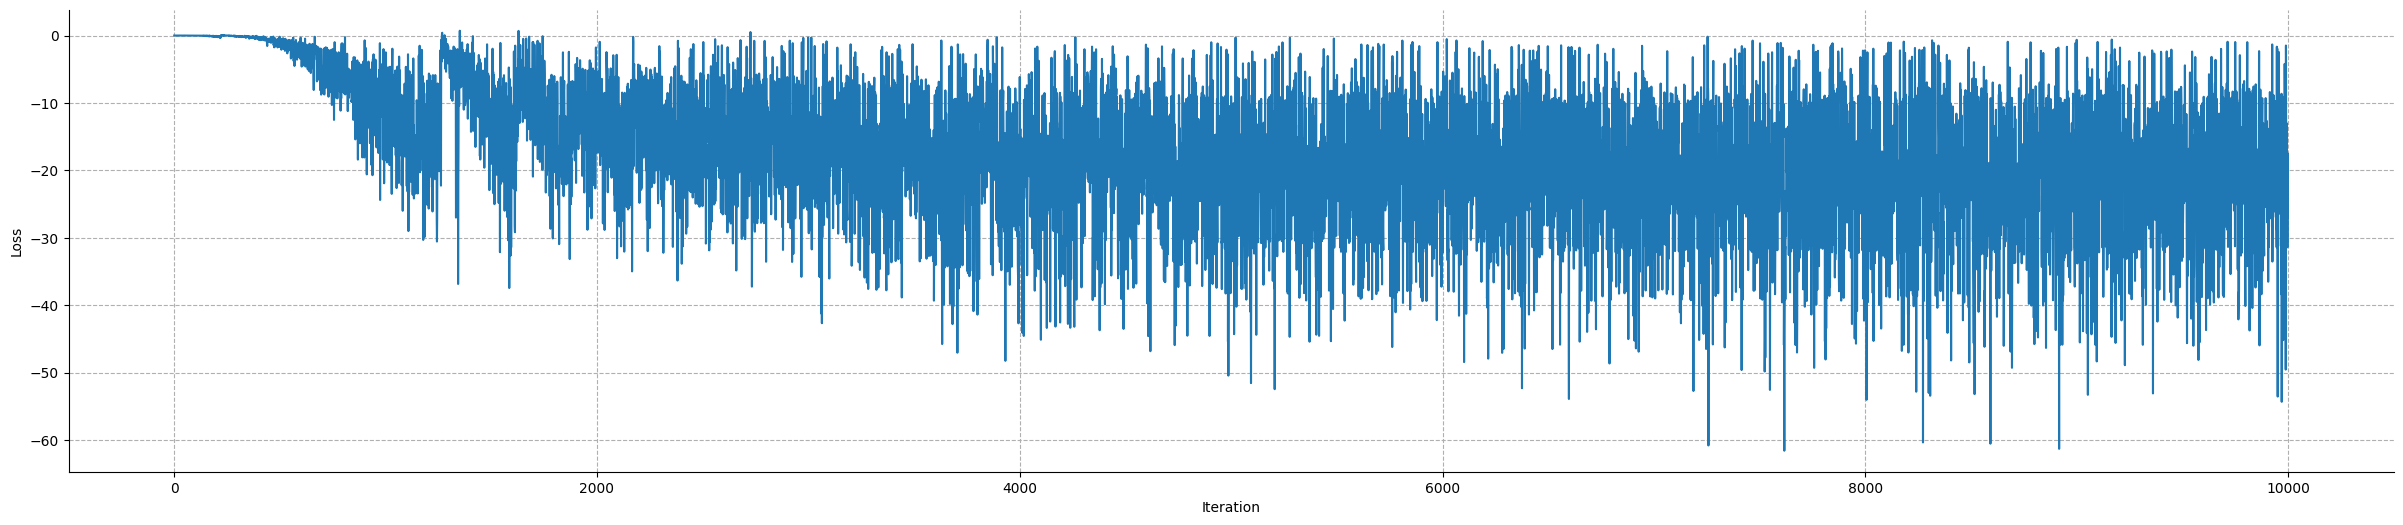

In [135]:
plt.figure(figsize=(30, 6))
plt.plot(optimized_U[1])
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--") 
plt.gca().spines[['right', 'top']].set_visible(False)


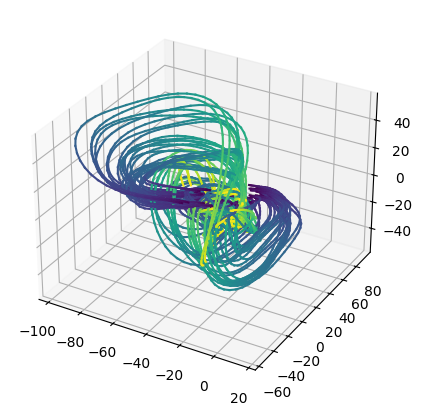

In [138]:
optimized_U_tilde, _ = jnp.linalg.qr(optimized_U[0])        
Y = jnp.einsum('ji,kjl->kil', optimized_U_tilde, X)         #(K,d,T)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = Y.shape[-1]
indices_to_plot = np.arange(0,Y.shape[0],1)

for i in indices_to_plot:
    x = Y[i, 0, :]  
    y = Y[i, 1, :] 
    z = Y[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))


In [139]:
def make_frame(angle):
    ax.view_init(30, angle)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0, 360, 2) 
frames = [make_frame(angle) for angle in angles]

gif_path = date_time_str + "_trajectories_rotation_test.gif"
imageio.mimsave(gif_path, frames, fps=20)

gif_path

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_46174/105152096.py:4: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


'07052024_164115_trajectories_rotation_test.gif'